In [30]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from kernel_sca import *
from utils import *
from kernels import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import wandb
from itertools import combinations

In [35]:
#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )

num_trajectories = 50
time_steps = 100

time = jnp.linspace(0, 4 *jnp.pi, time_steps)[:, jnp.newaxis]
radii = jnp.linspace(0.1, 2, num_trajectories)
phases = jnp.linspace(0, 2*jnp.pi, num_trajectories)

X = time + phases 
sine_waves = jnp.sin(X) * radii
cosine_waves = jnp.cos(X) * radii
X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)   #K=50, N=2, T=200

print(np.mean(compute_S(X)))
print(compute_S_all_pairs(X))
K, N, T = X.shape

# r = radii * np.cos(time + phases)
# theta = radii * np.sin(time + phases)
    
# x = r * np.cos(theta)
# y = r * np.sin(theta)
# X = jnp.stack([x.T, y.T], axis=1)
# K, N, T = X.shape

# for i in range(X.shape[0]):
#     plt.plot(x[:,i],y[:,i])

0.9768699
0.96609503


In [3]:


# expanded_X = jnp.zeros((K, 6, T))
# expanded_X = expanded_X.at[:, 0, :].set(1)  
# expanded_X = expanded_X.at[:, 1, :].set(jnp.sqrt(2) * X[:, 0, :])  # sqrt(2) * x1
# expanded_X = expanded_X.at[:, 2, :].set(jnp.sqrt(2) * X[:, 1, :])  # sqrt(2) * x2
# expanded_X = expanded_X.at[:, 3, :].set(jnp.sqrt(2) * X[:, 0, :] * X[:, 1, :])  # sqrt(2) * x1 * x2
# expanded_X = expanded_X.at[:, 4, :].set(X[:, 0, :]**2)  # x1^2
# expanded_X = expanded_X.at[:, 5, :].set(X[:, 1, :]**2)  # x2^2

In [12]:
# linewidth = 0.8
# plt.figure(figsize=(8,4))
# plt.subplot(1,2,1)
# plt.plot(sine_waves[:,0], color='black', linewidth = linewidth )
# plt.plot(cosine_waves[:,0], color='black', linewidth = linewidth)
# plt.subplot(1,2,2)
# plt.plot(sine_waves[:,0], cosine_waves[:,0], color='black', linewidth = linewidth)
# plt.gca().spines[['right', 'top']].set_visible(False)

(50, 100, 100)


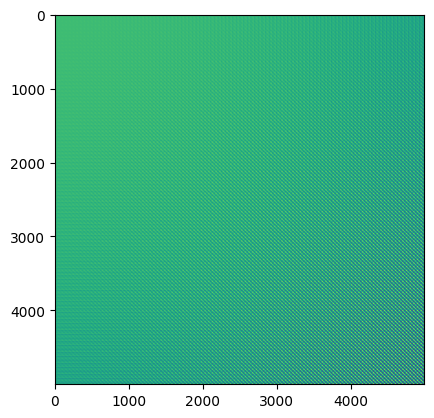

In [36]:
#RANDOM FOURIER FEATURES
## 
seed = 42


D = 50 #=N'
l = 5
mean = jnp.array([0.0, 0.0])  
covariance = jnp.array([[(1/l**2), 0.0], [0.0, (1/l**2)]])

key = random.PRNGKey(seed)
key, subkey = random.split(key)
samples_omega = random.multivariate_normal(key, mean, covariance, shape=(D,)) #(N',N) 

dot_prod = jnp.einsum('lj,ijk->ilk', samples_omega, X)                                  #(K, N', T)
K, _, T = dot_prod.shape

cos_values = jnp.cos(dot_prod)
sin_values = jnp.sin(dot_prod)
phi = jnp.hstack((cos_values, sin_values))  * (1 / jnp.sqrt(D))                           #(K, 2*N', T)                                     #(K, 2*N', T)


# b = random.uniform(key, shape=(1,D,1), minval=0.0, maxval=2*jnp.pi) 
# cos_values = jnp.cos( jnp.einsum('lj,ijk->ilk', samples_omega, X) + b )
# phi = jnp.sqrt(2 / D) * cos_values

# noise = random.normal(subkey, (phi.shape)) 
# phi += 0.001 * (noise) 

# plt.figure(figsize=(3,3))
# for i in range(num_trajectories):
#     plt.plot(phi[i,2,:], phi[i,52,:] )

# print( compute_S_all_pairs(phi) )

# # for i in range(5):
# plt.figure()
# plt.plot(phi[0,15,:] )
# #plt.plot(phi[0,65,:] )

cov = np.cov( np.concatenate(phi.swapaxes(1,2)) )
print(phi.shape)
#print(np.concatenate(phi.swapaxes(1,2)).shape)
plt.imshow(np.cov( np.concatenate(phi.swapaxes(1,2)) ))

0.0053626127


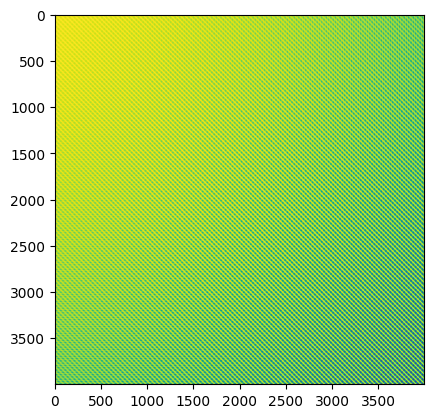

In [37]:
split = 10

X_train = phi[split:]
print( compute_S_all_pairs(X_train) )
X_test = phi[:split]
K, N, T = X_train.shape

A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)

# K_A_X = K_X_Y_identity(A, X_train)               #(K*T, K, T)
# K_A_A = K_X_Y_identity(A, A)

K_A_X = np.zeros((K*T, K, T))
for k in range(K):
    K_A_X[:,k,:] = K_X_Y_squared_exponential(A, X_train[k], l = l)
K_A_X = jnp.array(K_A_X)
K_A_A = jnp.array(K_X_Y_squared_exponential(A, A, l = l))

K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

plt.imshow(K_A_A)

In [38]:
d=2
wandb.init(project="SCA-project-toydata-kernel", name="run_1", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X_train, d=d, learning_rate=0.01, iterations=1000) 
wandb.finish
#np.save('alpha_tilde', alpha_tilde)

Iteration 0, S: 5.206673633906256e-12, S_ratio: 0.049706049263477325
Iteration 10, S: 4.924759385016575e-12, S_ratio: 0.03144516050815582
Iteration 20, S: 8.426885925172378e-12, S_ratio: 0.023422688245773315
Iteration 30, S: 3.2058060633194385e-12, S_ratio: 0.033616937696933746
Iteration 40, S: 8.975836567060025e-13, S_ratio: 0.00294306268915534
Iteration 50, S: 2.813578363347613e-12, S_ratio: 0.027975676581263542
Iteration 60, S: 4.533731029487953e-12, S_ratio: 0.056991055607795715
Iteration 70, S: 4.8241154994299595e-12, S_ratio: 0.04968110844492912
Iteration 80, S: 2.9198822179554718e-12, S_ratio: 0.05715663358569145
Iteration 90, S: 2.3850936416852653e-12, S_ratio: 0.148551344871521
Iteration 100, S: 2.4709581169374273e-12, S_ratio: 0.016039622947573662
Iteration 110, S: 2.804237744791216e-12, S_ratio: 0.010612624697387218
Iteration 120, S: 7.367756578446905e-12, S_ratio: 0.07750631868839264
Iteration 130, S: 2.6295742926868426e-12, S_ratio: 0.03726290166378021
Iteration 140, S: 4.

KeyboardInterrupt: 

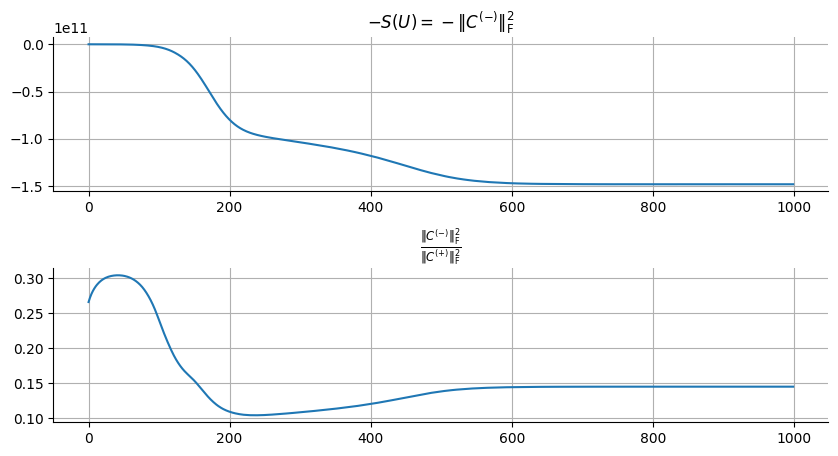

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

In [8]:
def plot_2D_clean(Y, fig, fontsize=13):
    #fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(121)
    cmap = plt.get_cmap('Blues_r')

    num_time_points = Y.shape[-1]
    indices_to_plot = np.arange(0,Y.shape[0],1)

    for i in indices_to_plot:
        x = Y[i, 0, :]  
        y = Y[i, 1, :] 
        
        for t in range(num_time_points - 1):
            ax.plot(x[t:t+2], y[t:t+2], color=cmap(t / (num_time_points - 1)), linewidth = 1)
    
    ax.spines[['top','right']].set_visible(False)
    ax.grid(False)  # Turn off the grid
    # ax.set_xticks([])  # Remove x-axis ticks
    # ax.set_yticks([])  # Remove y-axis ticks
    # ax.set_zticks([])  # Remove z-axis ticks

    ax.tick_params(axis='both', labelsize=fontsize)


Text(0.5, 1.0, 's = 0.001140694017522037')

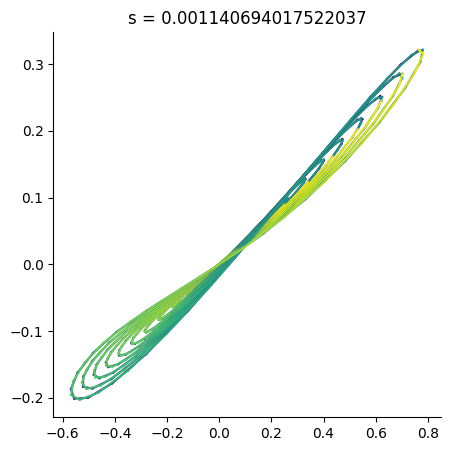

In [9]:
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)

# K_test, _, _ = X_test.shape
# K_A_X_test = np.zeros((K*T, K_test, T))
# for k in range(K_test):
#     K_A_X_test[:,k,:] = K_X_Y_squared_exponential(A, X_test[k], l = l)
# K_A_X_test = jnp.array(K_A_X_test)

K_A_X_test = K_X_Y_identity(A, X_test)                                     #(K*T, K, T)

# K_test, _, _ = X_test.shape
# K_A_X_test = np.zeros((K*T, K_test, T))
# for k in range(K_test):
#     K_A_X_test[:,k,:] = K_X_Y_polynomial(A, X_test[k])
# K_A_X_test = jnp.array(K_A_X_test)

projection = jnp.einsum('ij,imk->mjk', alpha_H, K_A_X_test[:,:,:])                #(K*T,d) @ (K*T, K, T) --> (K, d, T)
plot_2D(projection)
plt.title(f"s = {compute_S_all_pairs(projection)}")

In [ ]:

# linewidth=0.8
# fontsize=13
# # fig = plt.figure(figsize=(5, 4))
# # plot_2D_clean(X[:split], fig)

# fig = plt.figure(figsize=(10, 3))
# plot_2D_clean(projection, fig)
# #plt.title(f"s = {compute_S_all_pairs(projection)}")
# #fig = plt.figure(figsize=(5, 4))
# ax = fig.add_subplot(122)
# ax.plot(projection[7,0,:], color='black', linewidth=linewidth)
# ax.plot(projection[7,1,:], color='black', linewidth=linewidth)
# ax.spines[['top','right']].set_visible(False)
# ax.tick_params(axis='both', labelsize=fontsize)
# plt.subplots_adjust(wspace=0.6)

Text(0.5, 1.0, 'pca 0.94')

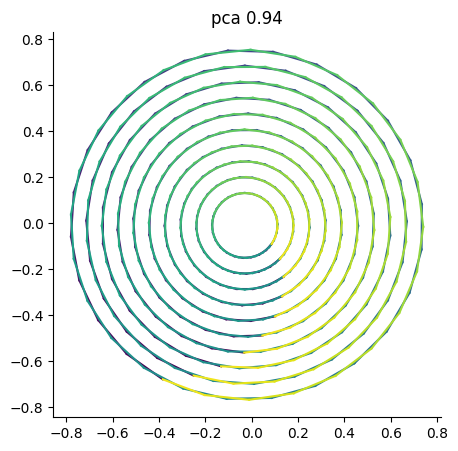

In [10]:
""" PCA """
X_train_pca = np.concatenate(X_train.swapaxes(1,2))
X_test_pca = np.concatenate(X_test.swapaxes(1,2))
full_data_var = np.sum(np.var(X_test, axis=0))

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_train_pca).transform(X_test_pca)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, time_steps, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
plt.title(f"pca {var_explained(X_test, PCs[:2].T):.2f}")




ENDS HERE

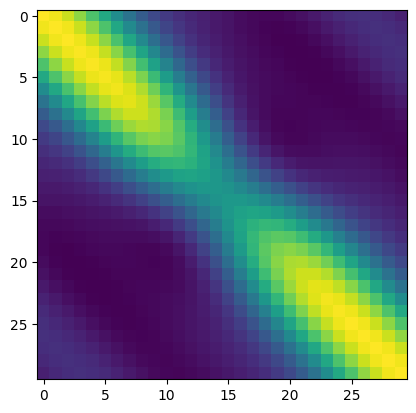

In [40]:
def sample_rff(
    x,
    kernel,
    lengthscale,
    coefficient,
    num_functions,
    num_features,
):
    
    # Dimension of data space
    x_dim = x.shape[-1]
    omega_shape = (num_functions, num_features, x_dim)
    
    # Handle each of three possible kernels separately
    if kernel == 'eq':
        omega = np.random.normal(size=omega_shape)
        
    elif kernel == 'laplace':
        omega =  np.random.standard_cauchy(size=omega_shape)
        
    elif kernel == 'cauchy':
        omega = np.random.laplace(size=omega_shape)
        
    # Scale omegas by lengthscale
    omega = omega / lengthscale
    
    weights = np.random.normal(
        loc=0.,
        scale=1.,
        size=(num_functions, num_features),
    )
    
    phi = np.random.uniform(
        low=0.,
        high=(2 * np.pi),
        size=(num_functions, num_features, 1),
    )
    
    #features = np.cos(np.einsum('sfd, nd -> sfn', omega, x) + phi)
    #features = (2 / num_features) ** 0.5 * features * coefficient

    features = np.einsum('sfd, nd -> sfn', omega, x)
    cos_values = jnp.cos(features)
    sin_values = jnp.sin(features)
    features = jnp.hstack((cos_values, sin_values))  * (1 / jnp.sqrt(num_features)) 
    
    #functions = np.einsum('sf, sfn -> sn', weights, features)
    functions=None
    
    return functions, features

lengthscale = 1.
coefficient = 1.
num_functions = 10
num_features = 50

# Input locations
x = np.linspace(-3., 3., 30)[:, None]

functions, features = sample_rff(x=x,       #features (K, N, T)
        kernel='eq', 
        lengthscale=lengthscale, 
        coefficient=coefficient, 
        num_functions=num_functions, 
        num_features=num_features,
    )

plt.imshow(np.cov(features[1].T))

In [ ]:
def projected_X_linear(X, seed = 42, proj_dims = 10, plot=False):
    key = random.PRNGKey(seed)
    key, subkey = random.split(key)

    #Project X
    proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
    X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
    
    #Observation noise 
    noise = random.normal(subkey, (X.shape)) 
    X += (noise)  /100
    X = jnp.array(X)

    if plot:
        plt.figure(figsize=(3,3))
        for i,initial_conditions in enumerate(initial_conditions_list):
            plt.plot(X[i,0,:],X[i,10,:] )
    return X

In [ ]:
def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - 1*x2 
    dx2_dt = 1*x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]


t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 400)     # time points where the solution is computed


num_trajectories = 150

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

plt.figure(figsize=(3,3))
for initial_conditions in initial_conditions_list:
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    plt.plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')

#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)                                                                        #(K, N, T)

np.mean(compute_S(X)) #np.mean(compute_S(X, iterations=100))

In [ ]:
# key = random.PRNGKey(0)
# perm_indices = random.permutation(key, len(radii))
# radii = radii[perm_indices]
